# Multiple-sequence alignment
Install [Jackhmmer](http://hmmer.org/documentation.html) with conda:
```bash
conda install -c bioconda hmmer
```

Get sequences database [UniRef50](ftp://ftp.uniprot.org/pub/databases/uniprot/uniref/uniref50/) (7.3GB download, 15GB uncompressed):
```bash
wget -q 'ftp://ftp.uniprot.org/pub/databases/uniprot/uniref/uniref50/uniref50.fasta.gz' 
gzip --decompress 'uniref50.fasta.gz'
```

Example run on one sequence:

```bash
cat << EOF > '/tmp/T0780.fasta'
>T0780 SP18142A - SP_1560, Streptococcus pneumoniae TIGR4, 259 residues
MKKNSLYIISSLFFACVLFVYATATNFQNSTSARQVKTETYTNTVTNVPIDIRYNSDKYF
ISGFASEVSVVLTGANRLSLASEMQESTRKFKVTADLTDAGVGTIEVPLSIEDLPNGLTA
VATPQKITVKIGKKAQKDKVKIVPEIDPSQIDSRVQIENVMVSDKEVSITSDQETLDRID
KIIAVLPTSERITGNYSGSVPLQAIDRNGVVLPAVITPFDTIMKVTTKPVAPSSSTSNSS
TSSSSETSSSTKATSSKTN
EOF

jackhmmer -o '/tmp/jackhmmer.out' -A '/tmp/alignments.sto' -N 3 -E .001 --cpu 8 '/tmp/T0780.fasta' 'uniref50.fasta'
```

In [1]:
%matplotlib agg
import io
import os
import re
import time
import json
import hashlib
import tarfile
import requests
import tempfile
import warnings
import functools
import contextlib
import subprocess
from pathlib import Path

import bs4
import docker
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation
import natsort as ns
import tqdm.notebook as tqdm

import Bio.PDB
import Bio.SeqIO
import Bio.Align.AlignInfo
import Bio.AlignIO

from loguru import logger
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Markdown, HTML, Video

from graphqa.data.aminoacids import *

pd.set_option("display.max_columns", 25)

In [2]:
alignments = Bio.AlignIO.parse("/tmp/alignments.sto", "stockholm")
for alignment in alignments:
    if alignment[0].id == 'T0780':
        break

original_sequence = [aa for aa in alignment[0] if aa != '-']
print(alignment)

Alignment with 6381 rows and 1068 columns
MKKNSLYII-SS--L-F-F--A-CVLFVYATATN-----F----...KTN T0780
LNNKWSIRI-IS--L-I-L--A-AILFTSVTADN-----N----...--- UniRef50_A0A0J8G9K6/6-239
--------------------------------------------...--- UniRef50_A0A0J8G9K6/228-341
--------------------------------------------...--- UniRef50_A0A0J8G9K6/346-453
-ESPWVLRI-LA--L-F-L--A-ILLYMSVNVEE-----V----...--- UniRef50_A0A0H4NUW9/6-238
--------------------------------------------...--- UniRef50_A0A0H4NUW9/230-335
--------------------------------DD-----N----...--- UniRef50_A0A0H4NUW9/332-438
IENRWFMRI-VG--L-L-L--A-FVLYVSVNFDE-----M----...--- UniRef50_A0A5D4NPP0/19-253
--------------------------------------------...--- UniRef50_A0A5D4NPP0/244-334
--------------------------------------------...--- UniRef50_A0A5D4NPP0/331-423
-RKNFSSLL-WA--L-L-L--S-VAVWIAAVTAA-----D----...--- UniRef50_A0A1F8TV62/6-222
--------------------------------------------...--- UniRef50_A0A1F8TV62/273-425
---------------------------------------

## Frequency count for each residue

BioPython implementation

In [3]:
def msa_counts_bio(alignment):
    original_sequence = [aa for aa in alignment[0] if aa != '-']
    summary_align = Bio.Align.AlignInfo.SummaryInfo(alignment)
    pssm = summary_align.pos_specific_score_matrix(alignment[0], chars_to_ignore=["-"])
    msa_counts = pd.DataFrame(
        [counts for aa, counts in pssm.pssm if aa != '-'], 
        dtype=np.int, 
        index=original_sequence,
    )
    return msa_counts

%timeit msa_counts_bio(alignment)

msa_counts = msa_counts_bio(alignment)
msa_counts

5.3 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,X,Y
M,0,0,0,0,0,0,0,74,0,294,149,0,0,0,0,0,0,9,0,0,0
K,22,0,59,75,3,1,12,4,306,7,16,215,0,68,192,87,283,0,1,0,0
K,18,0,63,166,0,12,149,2,390,1,0,526,5,92,282,347,58,4,0,0,3
N,3,0,261,54,0,4,56,9,314,2,1,1295,111,48,153,45,27,5,0,0,3
S,68,1,0,0,227,22,10,314,61,623,35,78,23,10,47,32,155,113,644,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S,1,0,10,7,0,1,1,0,1,0,0,3,2,3,1,47,9,3,0,0,0
S,6,0,4,5,0,0,0,0,0,0,0,4,0,0,0,46,10,0,0,0,0
K,1,0,15,7,0,0,0,0,2,0,0,5,0,1,0,9,2,0,0,0,0
T,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,2,0,0,0


Faster

In [4]:
bins = np.arange(22)
msa_1_mapping = {**aa_1_mapping, 'X': 21, '-': 22}
msa_1_mapping_inv = aa_1_mapping_inv + ['X']

def msa_counts_np(alignment):
    original_sequence = [aa for aa in alignment[0] if aa != "-"]
    seq_length = len(original_sequence)
    msa_counts = np.empty((seq_length, 21), dtype=np.int)
    
    idx_in_seq = 0
    for idx_in_msa, aa in enumerate(alignment[0]):
        if aa == '-':
            continue
        
        msa_at_idx = [msa_1_mapping[seq[idx_in_msa]] for seq in alignment]
        counts = np.histogram(msa_at_idx, bins=bins)[0]
        
        msa_counts[idx_in_seq] = counts
        idx_in_seq += 1
    
    msa_counts = pd.DataFrame(msa_counts, index=original_sequence, columns=msa_1_mapping_inv)
    return msa_counts

%timeit msa_counts_np(alignment)

msa_counts = msa_counts_np(alignment)
msa_counts.sort_index(axis='columns')

1.38 s ± 46.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,X,Y
M,0,0,0,0,0,0,0,74,0,294,149,0,0,0,0,0,0,9,0,0,0
K,22,0,59,75,3,1,12,4,306,7,16,215,0,68,192,87,283,0,1,0,0
K,18,0,63,166,0,12,149,2,390,1,0,526,5,92,282,347,58,4,0,0,3
N,3,0,261,54,0,4,56,9,314,2,1,1295,111,48,153,45,27,5,0,0,3
S,68,1,0,0,227,22,10,314,61,623,35,78,23,10,47,32,155,113,644,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S,1,0,10,7,0,1,1,0,1,0,0,3,2,3,1,47,9,3,0,0,0
S,6,0,4,5,0,0,0,0,0,0,0,4,0,0,0,46,10,0,0,0,0
K,1,0,15,7,0,0,0,0,2,0,0,5,0,1,0,9,2,0,0,0,0
T,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,2,0,0,0


## Partial entropy
$a$ = amino acid

$i$ = position in the sequence

$I_{i, a} = - p_{i, a} \log\frac{p_{i, a}}{\sum_j p_{j, a}}$

Below is not partial entropy, it's just normalized frequencies

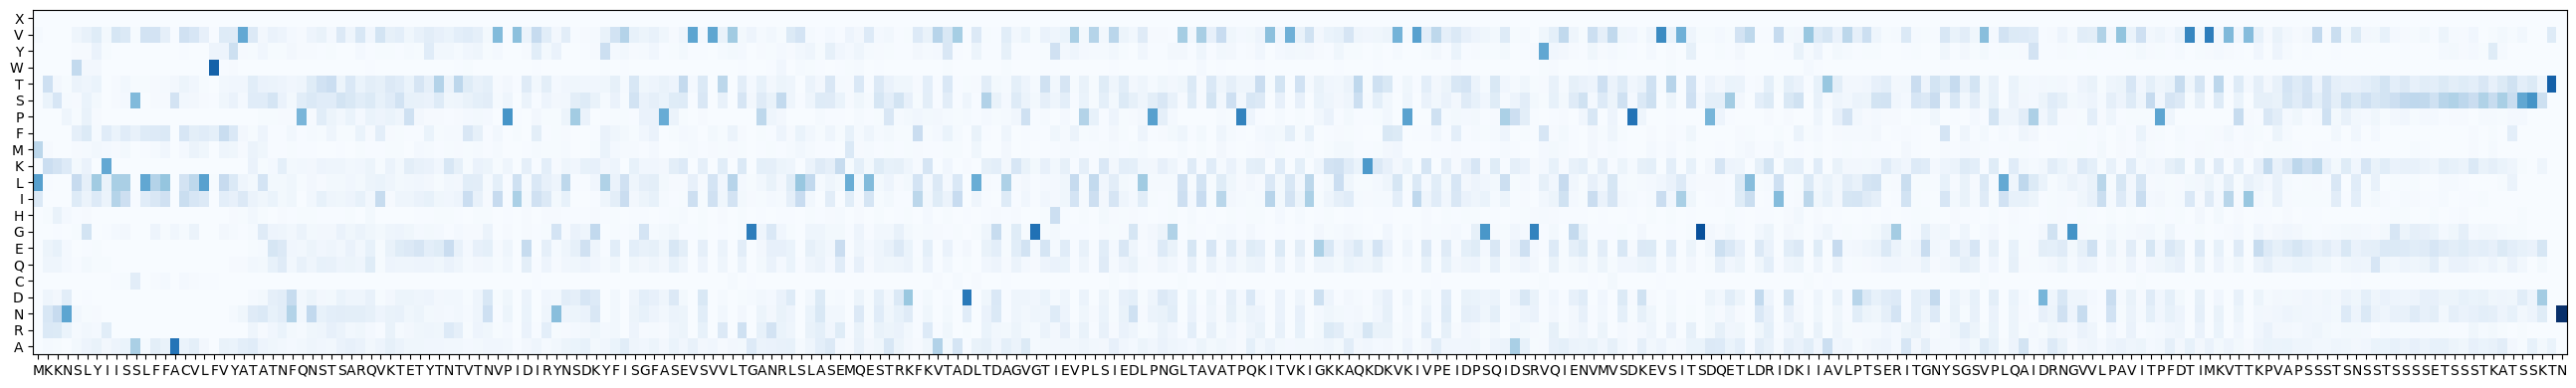

In [5]:
msa_counts = msa_counts.values
freq = msa_counts.astype(np.float) / msa_counts.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 1, figsize=(26, 4), tight_layout=True)
ax.pcolormesh(freq.T, cmap='Blues', vmin=0, vmax=1)
ax.set_xticks(np.arange(len(original_sequence))+.5)
ax.set_xticklabels(original_sequence)
ax.set_yticks(np.arange(len(aa_1_mapping_inv) + 1)+.5)
ax.set_yticklabels(aa_1_mapping_inv + ['X'])

fig.set_facecolor('white')
display(fig)
plt.close(fig)

## Process all data

In [6]:
%%bash
for ed in 9 10 11 12 13; do
  jackhmmer -N 3 -E .001 --incE 0.001 --cpu 4 \
    -o "CASP${ed}/jackhmmer.out" \
    -A "CASP${ed}/alignments.sto" \
    "CASP${ed}/sequences.fasta" 'uniref50.fasta' &
done
wait

du -shc CASP*/alignments.sto

24G	CASP10/alignments.sto
15G	CASP11/alignments.sto
21G	CASP12/alignments.sto
14G	CASP13/alignments.sto
18G	CASP9/alignments.sto
90G	total


In [7]:
def compute_and_save(casp_ed):
    path = f'CASP{casp_ed}/alignments.sto'
    all_msa_counts = {}
    for alignment in Bio.AlignIO.parse(path, format="stockholm"):
        target_id = alignment[0].id
        msa_counts = msa_counts_np(alignment)
        all_msa_counts[target_id] = msa_counts
    pd.to_pickle(all_msa_counts, f'CASP{casp_ed}/alignments.pkl')

with Parallel(n_jobs=5) as pool:
    pool(delayed(compute_and_save)(casp_ed) for casp_ed in [9, 10, 11, 12, 13])
    
! rm CASP*/alignments.sto
! du -shc CASP*/alignments.pkl

4.7M	CASP10/alignments.pkl
4.3M	CASP11/alignments.pkl
4.0M	CASP12/alignments.pkl
4.4M	CASP13/alignments.pkl
4.8M	CASP9/alignments.pkl
22M	total
